## COVID-CT-Dataset: A CT Scan Dataset about COVID-19

------------------------------------------------------------------------------------------------------------------

### Data Description

The COVID-CT-Dataset has 349 CT images containing clinical findings of COVID-19 from 216 patients. The images are collected from COVID19-related papers from medRxiv, bioRxiv, NEJM, JAMA, Lancet, etc. CTs containing COVID-19 abnormalities are selected by reading the figure captions in the papers. All copyrights of the data belong to the authors and publishers of these papers.

Citation: @article{zhao2020COVID-CT-Dataset,
  title={COVID-CT-Dataset: a CT scan dataset about COVID-19},
  author={Zhao, Jinyu and Zhang, Yichen and He, Xuehai and Xie, Pengtao},
  journal={arXiv preprint arXiv:2003.13865}, 
  year={2020}
}

### Summary

I am using 75 images for training set and 25 images as testing set

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2

%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.2)

from PIL import Image

# from sklearn.neural_network import MLPClassifier, MLPRegressor
# from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
# from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
# from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
# from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential, save_model
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
# from tensorflow.keras.optimizers import Adam

#For ANN and DNN
import keras
from keras.models import save_model, load_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten
from keras.optimizers import Adam, Adagrad, RMSprop, SGD

#For Convolutional Neural Networks
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)
tf.random.set_seed(0)

### Data Exploration

In [2]:
covid1 = cv2.imread(r'C:\Users\Dennis\Desktop\train\covid\1.png')
covid1 = cv2.cvtColor(covid1,cv2.COLOR_BGR2RGB)

In [3]:
covid1.shape

(335, 580, 3)

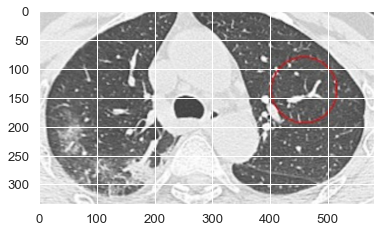

In [4]:
plt.imshow(covid1)
plt.show()

In [5]:
covid1.max()

255

In [6]:
noncovid1 = cv2.imread(r'C:\Users\Dennis\Desktop\train\ncovid\1.png')
noncovid1 = cv2.cvtColor(noncovid1,cv2.COLOR_BGR2RGB)

In [7]:
noncovid1.shape

(316, 512, 3)

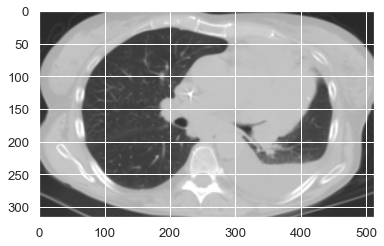

In [8]:
plt.imshow(noncovid1)
plt.show()

In [9]:
noncovid1.max()

255

## Convolutional Neural Networks for Image Classification

### Data Preprocessing

In [10]:
image_gen = ImageDataGenerator(rotation_range=30,  # rotate the image 30 degrees
                               width_shift_range=0.1,# Shift the pic width by a max of 10%
                               height_shift_range=0.1,# Shift the pic height by a max of 10%
                               rescale=1/255,# Rescale the image by normalzing it.
                               shear_range=0.2, # Shear means cutting away part of the image (max 20%)
                               zoom_range=0.2, # Zoom in by 20% max
                               horizontal_flip=True,# All horizontal flipping
                               fill_mode= "nearest" # Fill in missing pixels with the nearest filled value
                                )

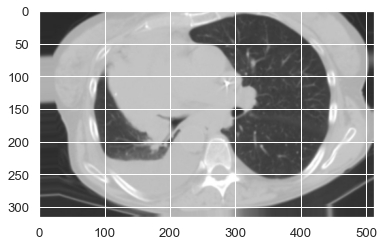

In [11]:
plt.imshow(image_gen.random_transform(noncovid1))

In [12]:
image_gen.flow_from_directory(r'C:\Users\Dennis\Desktop\train', target_size=(100, 100))

Found 150 images belonging to 2 classes.


In [13]:
image_gen.flow_from_directory(r'C:\Users\Dennis\Desktop\test', target_size=(100, 100))

Found 50 images belonging to 2 classes.


### Model Creation

In [14]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), input_shape=(100,100,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), input_shape=(100,100,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), input_shape=(100,100,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128,activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(Dense(units=128,activation='relu',kernel_regularizer='l2'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0

In [16]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=["accuracy"])

### Train Test Split

In [17]:
batch_size = 1

train_image_gen = image_gen.flow_from_directory(r'C:\Users\Dennis\Desktop\train', 
                                                target_size=(100,100), batch_size=batch_size,class_mode='binary')

Found 150 images belonging to 2 classes.


In [18]:
test_image_gen = image_gen.flow_from_directory(r'C:\Users\Dennis\Desktop\test', 
                                                target_size=(100,100), batch_size=batch_size,class_mode='binary')

Found 50 images belonging to 2 classes.


In [19]:
train_image_gen.class_indices

{'covid': 0, 'ncovid': 1}

### Model Training

In [21]:
results = model.fit_generator(train_image_gen,epochs=100,verbose=1,steps_per_epoch=1,
                   validation_data=test_image_gen,validation_steps=1)

Epoch 1/100
1/1 [==============================] - 0s 69ms/step - loss: 1.0411 - accuracy: 0.0000e+00 - val_loss: 0.5288 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 100ms/step - loss: 0.4929 - accuracy: 1.0000 - val_loss: 0.5176 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 62ms/step - loss: 0.8042 - accuracy: 0.0000e+00 - val_loss: 0.5622 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 0.5386 - accuracy: 1.0000 - val_loss: 0.8234 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 62ms/step - loss: 0.5878 - accuracy: 1.0000 - val_loss: 0.4671 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 53ms/step - loss: 0.5544 - accuracy: 1.0000 - val_loss: 0.5860 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 53ms/step - loss: 0.5940 - accuracy: 1.0000 - val_loss: 0.4994 - val_accuracy: 1.0000
Epoch 8

1/1 [==============================] - 0s 47ms/step - loss: 0.7482 - accuracy: 0.0000e+00 - val_loss: 0.7099 - val_accuracy: 0.0000e+00
Epoch 59/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6432 - accuracy: 1.0000 - val_loss: 0.6468 - val_accuracy: 1.0000
Epoch 60/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6365 - accuracy: 1.0000 - val_loss: 0.6909 - val_accuracy: 1.0000
Epoch 61/100
1/1 [==============================] - 0s 47ms/step - loss: 0.4309 - accuracy: 1.0000 - val_loss: 0.0844 - val_accuracy: 1.0000
Epoch 62/100
1/1 [==============================] - 0s 47ms/step - loss: 0.7711 - accuracy: 0.0000e+00 - val_loss: 0.4685 - val_accuracy: 1.0000
Epoch 63/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6271 - accuracy: 1.0000 - val_loss: 0.6269 - val_accuracy: 1.0000
Epoch 64/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6070 - accuracy: 1.0000 - val_loss: 0.7719 - val_accuracy: 0.0000e+00
Epoch 65/1

### Model Evaluation

In [22]:
model.metrics_names

['loss', 'accuracy']

In [23]:
results.history['accuracy']

[0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0]

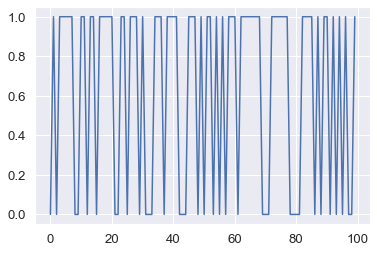

In [24]:
plt.plot(results.history['accuracy'])
plt.show()

### Model Prediction

In [25]:
train_image_gen.class_indices

{'covid': 0, 'ncovid': 1}

In [26]:
covid_file = "test.png"

In [27]:
covid_img = image.load_img(covid_file, target_size=(100,100))

In [28]:
covid_img = image.img_to_array(covid_img)

In [29]:
covid_img

array([[[ 26.,  26.,  26.],
        [ 24.,  24.,  24.],
        [ 26.,  26.,  26.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [129., 129., 129.]],

       [[ 24.,  24.,  24.],
        [ 24.,  24.,  24.],
        [ 24.,  24.,  24.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [129., 129., 129.]],

       [[ 24.,  24.,  24.],
        [ 24.,  24.,  24.],
        [ 24.,  24.,  24.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [129., 129., 129.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [129., 129., 129.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [129., 129., 129.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  

In [30]:
covid_img.shape

(100, 100, 3)

In [31]:
covid_img = np.expand_dims(covid_img,axis=0)

In [32]:
covid_img.shape

(1, 100, 100, 3)

In [33]:
covid_img = covid_img/255

In [34]:
model.predict_classes(covid_img)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0]])

In [35]:
model.predict(covid_img)  #Predicted correctly

array([[0.47945264]], dtype=float32)

### Save the Model

In [36]:
model.save("covid.h5")